In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import savgol_filter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sshtunnel import SSHTunnelForwarder
from sqlalchemy import create_engine

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Database access

Connect to the database hosting my data  

Data from:  
https://www.consumerfinance.gov/data-research/consumer-complaints/  
https://www.consumerfinance.gov/data-research/credit-card-data/

In [2]:
# SSH config shortcut
SSH_CONFIG_SHORTCUT = 'myaws'

server = SSHTunnelForwarder(
    SSH_CONFIG_SHORTCUT,
    ssh_config_file='~/.ssh/config',
    remote_bind_address=('localhost', 5432)
)

server.start()
print(server.is_active, server.is_alive, server.local_bind_port)

True True 50753


In [3]:
# Postgres username, password, and database name
POSTGRES_IP_ADDRESS = 'localhost' ## This is localhost because SSH tunnel is active
POSTGRES_PORT = str(server.local_bind_port)
POSTGRES_USERNAME = '*******'     ## CHANGE THIS TO YOUR POSTGRES USERNAME
POSTGRES_PASSWORD = '*******' ## CHANGE THIS TO YOUR POSTGRES PASSWORD
POSTGRES_DBNAME = 'cfpb'

# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME, 
                        password=POSTGRES_PASSWORD,
                        ipaddress=POSTGRES_IP_ADDRESS,
                        port=POSTGRES_PORT,
                        dbname=POSTGRES_DBNAME))

# Create the connection
cnx = create_engine(postgres_str)

# Test Queries

In [6]:
pd.read_sql_query('SELECT * FROM cc_plans LIMIT 5', cnx);

In [5]:
pd.read_sql_query('''SELECT "Agreement_Date", date_part('year', "Agreement_Date") as yr,\
                    AVG("APR") as mean_apr, \
                    AVG("Grace_Period") as mean_grace,
                    AVG("Annual_Fee") as ann_fee
                FROM cc_plans\
                GROUP BY "Agreement_Date"\
                ORDER BY "Agreement_Date" \
                DESC LIMIT 7;''', cnx);

In [ ]:
#Testing queries
pd.read_sql_query('''SELECT DISTINCT ON (id) * 
                        FROM complaints\
                        INNER JOIN 
                            (SELECT "Agreement_Date", 
                                AVG("APR") as mean_apr, 
                                AVG("Grace_Period") as mean_grace,
                                AVG("Annual_Fee") as ann_fee
                            FROM cc_plans\
                            GROUP BY "Agreement_Date"\
                            ORDER BY "Agreement_Date"\
                            DESC LIMIT 20) as tbl2\
                        ON tbl2."Agreement_Date" <= complaints.date_received 
                    ORDER BY id DESC
                    LIMIT 7;''', cnx);

In [ ]:
#Version 1
df = pd.read_sql_query('''SELECT * FROM complaints''', cnx)

In [ ]:
#Version 2
df = pd.read_sql_query('''SELECT * FROM complaints\
                        INNER JOIN 
                            (SELECT date_part('year', "Agreement_Date") as yr, 
                                    AVG("APR") as mean_apr, 
                                    AVG("Grace_Period") as mean_grace,
                                    AVG("Annual_Fee") as ann_fee
                                FROM cc_plans\
                                GROUP BY yr\
                                ORDER BY yr \
                                DESC LIMIT 7) as tbl2\
                        ON tbl2.yr = date_part('year', complaints.date_received);''', cnx)

In [ ]:
#Version 3
df = pd.read_sql_query('''SELECT DISTINCT ON (id) * 
                        FROM complaints\
                        INNER JOIN 
                            (SELECT "Agreement_Date", 
                                AVG("APR") as mean_apr, 
                                AVG("Grace_Period") as mean_grace,
                                AVG("Annual_Fee") as ann_fee
                            FROM cc_plans\
                            GROUP BY "Agreement_Date"\
                            ORDER BY "Agreement_Date"\
                            DESC LIMIT 20) as tbl2\
                        ON tbl2."Agreement_Date" <= complaints.date_received 
                    WHERE date_part('year', date_received) > 2016
                    ORDER BY id DESC;''', cnx)

# Consolidate the loading, cleaning and feature engineering

In [4]:
def load_data(cnx):
    print('loading')
    return pd.read_sql_query('''SELECT DISTINCT ON (id) * 
                        FROM complaints
                        INNER JOIN 
                            (SELECT "Agreement_Date", 
                                AVG("APR") as mean_apr, 
                                AVG("Grace_Period") as mean_grace,
                                AVG("Annual_Fee") as ann_fee
                            FROM cc_plans
                            GROUP BY "Agreement_Date"
                            ORDER BY "Agreement_Date"
                            DESC LIMIT 20) as tbl2
                        ON tbl2."Agreement_Date" <= complaints.date_received 
                    ORDER BY id DESC;''', cnx)

In [5]:
def clean_data(df):
    print('cleaning:')
    #encode disputed as binary
    df['disputed'].replace({'No': 0, "Yes": 1}, inplace=True)
    df['timely'].replace({'No': 0, "Yes": 1}, inplace=True)
    
    #impute missing values with 0 (assume no escalation)
    df['disputed'].fillna(0, inplace=True)
    df['disputed'].replace('N/A', 0, inplace=True)

    #FEATURE: parse the tags into separate binary variables
    df['tags'].fillna('', inplace=True)
    df['older'] = df['tags'].apply(lambda x: 'older' in x.lower())
    df['service_member'] = df['tags'].apply(lambda x: 'service' in x.lower())

    #FEATURE: did the complaint have a narrative?
    df['narrative'].replace(np.nan, '',inplace=True)
    df['has_narr'] = df['narrative'].apply(lambda x: len(x) > 0)
    df['narr_len'] = df['narrative'].apply(lambda x: len(x.split(' ')))

    #FEATURE: how long did it take for the business to get the complaint?
    df['date_difference'] = pd.to_numeric(df['date_sent'] - df['date_received'])/86400/10**9
    
    df['date_received'] = pd.to_datetime(df['date_received'])
    df['weekday'] = df['date_received'].apply(lambda x: x.weekday())
    
    #FEATURE: consolidate issue columns into more general categories based on keywords
    df['short_issue'] = None

    keywords = ['sold', 'wrong', 'disclos', 'reward', 'money', 'statement', 'process', 'transfer',\
                'transaction', 'identity', 'report', 'appl', 'card', 'advertising',\
               'account', 'lender', 'fee', 'information', 'pay', 'customer', 'problem', 'other', 'credit']

    for word in keywords:
        df.loc[df['issue'].apply(lambda x: word in x.lower()), 'short_issue'] = word

    legal_words = ['action','fraud', 'improper', 'dispute', 'privacy', 'arbitration']
    bank_words = ['deposit', 'cash', 'check', 'bank', 'exchange']
    debt_words = ['debt', 'collection', 'bankrupt', 'apr', 'plan']
    loan_words = ['mortgage', 'loan']
    comm_words = ['communication']

    df.loc[df['issue'].apply(lambda x: any(word in x.lower() for word in legal_words)), 'short_issue'] = 'legal'
    df.loc[df['issue'].apply(lambda x: any(word in x.lower() for word in bank_words)), 'short_issue'] = 'bank'
    df.loc[df['issue'].apply(lambda x: any(word in x.lower() for word in debt_words)), 'short_issue'] = 'debt'
    df.loc[df['issue'].apply(lambda x: any(word in x.lower() for word in loan_words)), 'short_issue'] = 'loan'
    df.loc[df['issue'].apply(lambda x: any(word in x.lower() for word in comm_words)), 'short_issue'] = 'communication'
    
    #FEATURE: Consolidate subissues
    df['short_subissue'] = None
    shortList = list(df.groupby('subissue')['disputed'].mean().apply(lambda x: x != 0).index)
    df['short_subissue'] = df['subissue'].apply(lambda x: x in shortList)
    
    print('done')
    return df


In [6]:
#downsample the dataset to balance the classes
def down_sample(df):
    pos_ex = df[df.disputed==1]
    sample_size = pos_ex.shape[0]
    neg_ex = df.loc[np.random.choice(df[df.disputed == 0].index, sample_size, replace=False)]

    df_downsample = pos_ex.append(neg_ex)
    return df_downsample

In [7]:
df = clean_data(load_data(cnx))

loading
cleaning:
done


# Data Exploration

In [9]:
df.shape

(815290, 30)

In [ ]:
df.head()

In [260]:
#Overall dispute rate
df['disputed'].mean()

0.18199413705552625

In [41]:
#products with the most complaints
df[df['date_received'].dt.year>=2015].groupby('product')['disputed'].count().sort_values(ascending=False).head(7)

product
Debt collection            105448
Mortgage                   101191
Credit reporting            94929
Bank account or service     45944
Credit card                 45498
Student loan                24736
Consumer Loan               21044
Name: disputed, dtype: int64

In [42]:
#issues with the most complaints
df[df['date_received'].dt.year>=2015].groupby('issue')['disputed'].count().sort_values(ascending=False).head(7)

issue
Incorrect information on credit report      70328
Cont'd attempts collect debt not owed       40282
Loan modification,collection,foreclosure    38910
Loan servicing, payments, escrow account    38268
Disclosure verification of debt             22177
Account opening, closing, or management     20864
Dealing with my lender or servicer          15290
Name: disputed, dtype: int64

In [29]:
#contentious products since 2015
df[df['date_received'].dt.year>=2015].groupby('product')['disputed'].mean().sort_values(ascending=False).head(7)

product
Virtual currency           0.470588
Consumer Loan              0.205664
Credit card                0.204295
Mortgage                   0.201658
Other financial service    0.188901
Bank account or service    0.175104
Student loan               0.162314
Name: disputed, dtype: float64

In [31]:
#contentious issues since 2015
df[df['date_received'].dt.year>=2015].groupby('issue')['disputed'].mean().sort_values(ascending=False).head(7)

issue
Lender damaged or destroyed property    0.500000
Lender sold the property                0.500000
Cash advance                            0.288462
Rewards                                 0.272825
Settlement process and costs            0.269319
Credit line increase/decrease           0.262729
Lost or stolen check                    0.261905
Name: disputed, dtype: float64

In [34]:
#get average dispute rates by category
df.groupby(['product'])['disputed'].mean().sort_values(ascending=False).head(10)

product
Virtual currency           0.470588
Consumer Loan              0.205664
Credit card                0.204295
Mortgage                   0.201658
Other financial service    0.188901
Bank account or service    0.175104
Student loan               0.162314
Debt collection            0.158713
Credit reporting           0.153367
Money transfers            0.150028
Name: disputed, dtype: float64

In [44]:
#average dispute rate by issue
df.groupby('issue')['disputed'].mean().sort_values(ascending=False).head(10)

issue
Lender damaged or destroyed property    0.500000
Lender sold the property                0.500000
Cash advance                            0.288462
Rewards                                 0.272825
Settlement process and costs            0.269319
Credit line increase/decrease           0.262729
Lost or stolen check                    0.261905
Privacy                                 0.254237
Forbearance / Workout plans             0.253807
Advertising and marketing               0.246145
Name: disputed, dtype: float64

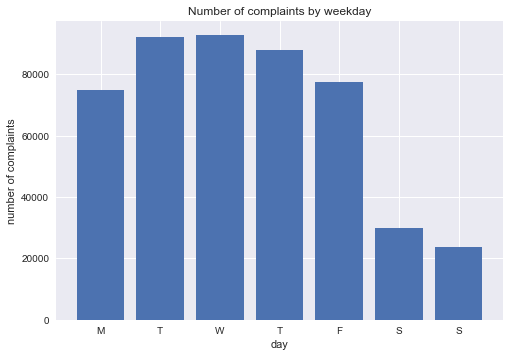

In [117]:
#How does the dispute rate vary over time?

a = df[df['date_received'].dt.year>=2015].groupby('weekday')['disputed'].count()
plt.bar(a.index, a)
#plt.plot(a.index, a.shape[0]*[0.2], 'r')
plt.xlabel('day')
plt.ylabel('number of complaints')
plt.xticks(range(7), ('M', 'T', 'W', 'T', 'F', 'S', 'S'));
plt.title('Number of complaints by weekday')

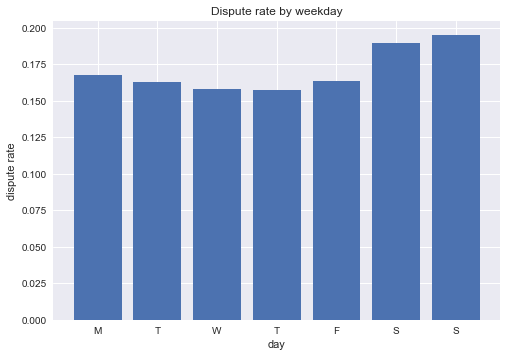

In [112]:
#How does the dispute rate vary over time?
a = df[df['date_received'].dt.year>=2015].groupby('weekday')['disputed'].mean()
plt.bar(a.index, a)
plt.xlabel('day')
plt.ylabel('dispute rate')
plt.xticks(range(7), ('M', 'T', 'W', 'T', 'F', 'S', 'S'));
plt.title('Dispute rate by weekday')

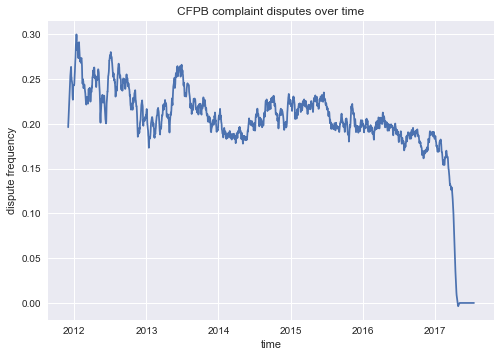

In [19]:
a = df.groupby('date_received')['disputed'].mean()

b = savgol_filter(a,31, 3) #Savitzky–Golay filter to clean up the signal a bit
plt.plot(a.index, b)
#plt.scatter(a.index, a)
#plt.plot(a.index, a.shape[0]*[0.2], 'r')
plt.xlabel('time')
plt.ylabel('dispute frequency')
plt.title('CFPB complaint disputes over time')

# Train/Test Split

Standard train_test split.  Downsample the training data to balance the frequencies of target labels (disputed or not disputed?)

No sensitivity to time.

In [106]:
#Clean, train/test split
def tt_split(df, date_start, date_end):
    df2 = shuffle(df[(df['date_received'] >= date_start)& (df['date_received'] <= date_end)])


    cols = ['older', 'narr_len', 'service_member', 'product','timely', 'submitted_via', 'short_issue', 'short_subissue', 'cust_response', 'has_narr', 'date_difference', 'mean_apr', 'mean_grace']

    y = df2['disputed']
    X = pd.get_dummies(df2[[c for c in cols if c != 'disputed']])
    
    return train_test_split(X, y, test_size=0.5, random_state=4444)

In [110]:
start = datetime.strptime('2015-01-01', '%Y-%m-%d')
end = datetime.strptime('2017-08-01', '%Y-%m-%d')

X_train, X_val, y_train, y_val = tt_split(df, start, end)

In [111]:
print(X_train.shape)
print(X_val.shape)
print(y_val.mean())

(239559, 64)
(239559, 64)
0.16441043751226211


# Moving average train/test split (years)

Use data from one year to predict data in another year

In [120]:
def train_test_split_year(df, years_train, year_test):
    #columns used as features in the model
    cols = ['older', 'narr_len', 'service_member', 'product','timely', 'submitted_via',\
            'short_issue', 'short_subissue', 'cust_response', 'has_narr', \
            'date_difference', 'mean_apr', 'mean_grace', 'disputed', 'date_received', 'weekday']
    
    df2 = pd.get_dummies(df[cols])
    
    train_df = down_sample(df2[df2['date_received'].dt.year.isin(years_train)].drop('date_received', axis=1))
    test_df = df2[df['date_received'].dt.year == year_test].drop('date_received', axis=1)
    
    y_train = train_df['disputed']
    X_train = train_df[[c for c in train_df.columns if c != 'disputed']]
    
    y_val = test_df['disputed']
    X_val = test_df[[c for c in test_df.columns if c != 'disputed']]
    
    return (X_train, X_val, y_train, y_val)

In [184]:
X_train, X_val, y_train, y_val = train_test_split_year(df, [2012, 2013], 2014)

In [245]:
latest_date = df['date_received'].max()
cutoff = latest_date - relativedelta(days=7)
cutoff

Timestamp('2017-07-12 00:00:00')

# Moving Average (days)

Use data from a specific time interval.  Test data is the last N days in the interval, training data is everything before that.  

This was the train-test-split used in the final model

In [8]:
def train_test_split_window(df, date_start, date_end, days):
    cols = ['older', 'narr_len', 'service_member', 'product','timely', 'submitted_via',\
            'short_issue', 'short_subissue', 'cust_response', 'has_narr', \
            'date_difference', 'mean_apr', 'mean_grace', 'disputed', 'date_received', 'weekday']
    
    df2 = pd.get_dummies(df[cols])
    df2 = df2[(df2['date_received'] >= date_start) & (df2['date_received'] <= date_end)]
    
    latest_date = df2['date_received'].max()
    cutoff = latest_date - relativedelta(days=days)
    
    train_df = down_sample(df2[df2['date_received'] <= cutoff].drop('date_received', axis=1))
    test_df = df2[df2['date_received'] > cutoff].drop('date_received', axis=1)
    
    y_train = train_df['disputed']
    X_train = train_df[[c for c in train_df.columns if c != 'disputed']]
    
    y_val = test_df['disputed']
    X_val = test_df[[c for c in test_df.columns if c != 'disputed']]
    
    return (X_train, X_val, y_train, y_val)

In [9]:
start = datetime.strptime('2015-01-01', '%Y-%m-%d')
end = start + relativedelta(years=2, days=7)

X_train, X_val, y_train, y_val = train_test_split_window(df, start, end, 7)

In [10]:
print(X_train.shape)
print(X_val.shape)
print(y_val.mean())

(138180, 67)
(3556, 67)
0.1889763779527559


# Model testing

Gradient Boosting had the most consistent performance

Random Forest had a tendency to overfit

In [14]:
models = [GradientBoostingClassifier(n_estimators=150, verbose=1),\
          RandomForestClassifier(n_jobs=-1, n_estimators=50, max_depth=9, criterion ='entropy'), BernoulliNB()]
labels = ['Gradient Boosting', 'Random Forest', 'Naive Bayes']

#models = [RandomForestClassifier(n_jobs=-1, n_estimators=50, max_depth=9, criterion ='entropy')]
#labels = ['Random Forest']

trained = []
for model, label in zip(models,labels):
    print('Training', label + ':')
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)
    trained.append(pipe)
    print('done')

Training Gradient Boosting:
      Iter       Train Loss   Remaining Time 
         1           1.3773           39.44s
         2           1.3700           41.49s
         3           1.3640           40.16s
         4           1.3591           40.70s
         5           1.3551           40.49s
         6           1.3517           40.68s
         7           1.3489           41.39s
         8           1.3466           41.98s
         9           1.3445           41.46s
        10           1.3427           41.71s
        20           1.3315           41.61s
        30           1.3260           36.08s
        40           1.3229           31.56s
        50           1.3210           28.21s
        60           1.3195           25.33s
        70           1.3184           22.25s
        80           1.3175           19.26s
        90           1.3168           16.45s
       100           1.3161           13.55s
done
Training Random Forest:
done
Training Naive Bayes:
done


In [15]:
#Voting Classifier

models = [GradientBoostingClassifier(n_estimators=150), \
          RandomForestClassifier(n_estimators=50, max_depth=13),\
           BernoulliNB()]
labels2 = ['GB', 'RF', 'Naive Bayes']

voter = VotingClassifier(list(zip(labels, models)), n_jobs=-1, voting ='soft', weights = [1,1, 1])
vote_pipe = make_pipeline(StandardScaler(), voter)
print('training')
vote_pipe.fit(X_train, y_train)
print('done')

trained.append(vote_pipe)
labels.append('Voting Classifier')


training
done


Evaluating: Gradient Boosting 

Accuracy: 0.569178852643
Scope Reduction: 0.474128233971
Train AUC 0.644960466567
Test AUC: 0.63890135848
Train Precision: 0.590113079155
Test Precision: 0.244958481613
Train Recall: 0.682819510783
Test Recall: 0.614583333333

Evaluating: Random Forest 

Accuracy: 0.52727784027
Scope Reduction: 0.532902137233
Train AUC 0.647297009145
Test AUC: 0.63294768757
Train Precision: 0.587527872208
Test Precision: 0.233773087071
Train Recall: 0.69791576205
Test Recall: 0.659226190476

Evaluating: Naive Bayes 

Accuracy: 0.580708661417
Scope Reduction: 0.460348706412
Train AUC 0.623047305876
Test AUC: 0.625147313173
Train Precision: 0.588876293042
Test Precision: 0.249847281613
Train Recall: 0.60149080909
Test Recall: 0.608630952381

Evaluating: Voting Classifier 

Accuracy: 0.55764904387
Scope Reduction: 0.48790776153
Train AUC 0.647919705232
Test AUC: 0.635573783518
Train Precision: 0.598309435179
Test Precision: 0.240345821326
Train Recall: 0.644405847445
Test R

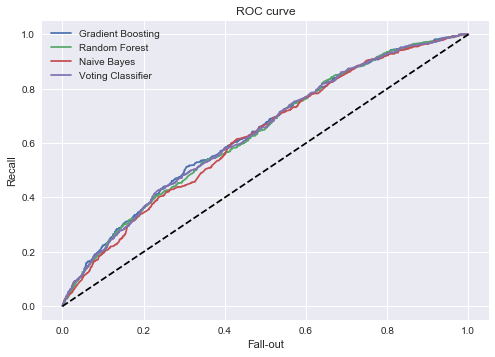

In [16]:
#thresh=0.2 => recall ~= 0.995
#thresh = 0.23 => recall ~= 0.99
thresh = 0.5

for mdl, label in zip(trained, labels):
    print('Evaluating:', label, '\n')
    y_prob = mdl.predict_proba(X_val)[:,1]
    y_pred = [pred >= thresh for pred in y_prob]

    y_prob_train = mdl.predict_proba(X_train)[:,1]
    y_pred_train = [pred >= thresh for pred in y_prob_train]

    print('Accuracy:', accuracy_score(y_val, y_pred))
    print('Scope Reduction:', sum(y_pred)/len(y_val))
    precision = precision_score(y_val, y_pred)

    print('Train AUC', roc_auc_score(y_train, y_prob_train))
    print('Test AUC:', roc_auc_score(y_val, y_prob))

    print('Train Precision:', precision_score(y_train, y_pred_train))
    print('Test Precision:', precision)

    print('Train Recall:', recall_score(y_train, y_pred_train))
    print('Test Recall:', recall_score(y_val, y_pred))

    #conf = confusion_matrix(y_val, y_pred)

    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=label);
    print('')
    
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Fall-out')
plt.ylabel('Recall')
plt.title('ROC curve')

plt.legend();

In [34]:
#feature importances in random forest
sorted(list(zip(X_train.columns,trained[1].steps[1][1].feature_importances_)), key = lambda x: x[1], reverse=True)

[('cust_response_Closed with explanation', 0.14619161284730184),
 ('narr_len', 0.11444563447576712),
 ('cust_response_Closed with non-monetary relief', 0.10180356162862163),
 ('submitted_via_Web', 0.095280806609042423),
 ('has_narr', 0.052973306477102487),
 ('date_difference', 0.048756566740415931),
 ('cust_response_Untimely response', 0.043744291669399048),
 ('cust_response_Closed with monetary relief', 0.03876764115789319),
 ('short_subissue', 0.035892101502423987),
 ('submitted_via_Postal mail', 0.02977644395503844),
 ('mean_apr', 0.027304114688475309),
 ('mean_grace', 0.02487604520906915),
 ('short_issue_credit', 0.022868678235764439),
 ('submitted_via_Referral', 0.022186573922694578),
 ('weekday', 0.019890000530380817),
 ('submitted_via_Phone', 0.016763668619789614),
 ('product_Mortgage', 0.015714715727025035),
 ('product_Credit reporting', 0.015440876964521382),
 ('short_issue_loan', 0.014824769330985614),
 ('cust_response_Closed', 0.014122169956498625),
 ('timely', 0.01405620365

In [20]:
server.close()